In [1]:
from radio_z import hifit, saxdata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%matplotlib nbagg

Read in the catalogue with the SAX parameters from an HDF5 file

In [35]:
rt = '/home/michelle/Project/HI_fit/sub_z/cats/'
name = 'snr10_cat'
cat_name = rt+name+'.h5'

In [36]:
surv = saxdata.Survey('ska1_band1')
cat = saxdata.SaxCatalogue(cat_name)
cat_df = cat.get_data()

Create the mock HI data from the SAX parameters for the whole catalogue

In [37]:
make_new_data = False
data_maker = saxdata.DataFromCatalogue()

if make_new_data:
    dat = data_maker.create_from_cat(cat_df, surv, rt+name+'_data.hdf5')
else:
    dat = pd.HDFStore(rt+name+'_data.hdf5','r')

In [46]:
ind = dat.keys()[4]
df = dat[ind]
ind

'/ID87659518'

Each object is stored in a separate dataframe in the HDF5 file. We can plot an example profile to have a look.

<IPython.core.display.Javascript object>


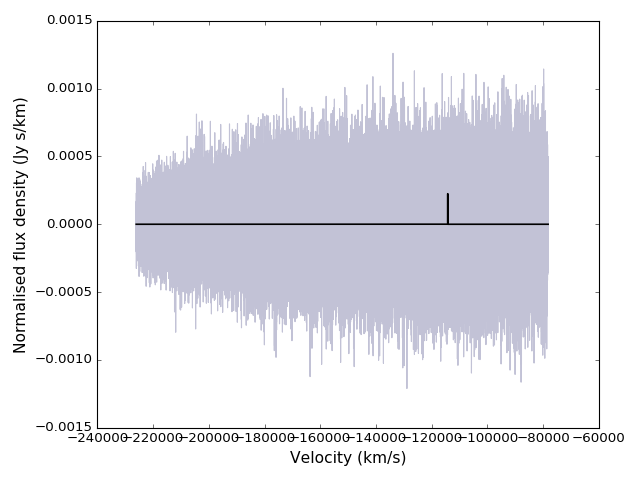

In [47]:
plt.figure()
data_maker.plot_profile(df, plot_model=True, model_params=cat.get_params(cat_df,ind[1:]), zoom=False)

This object allows us to fit the whole catalogue, in parallel if requested

In [24]:
fc = hifit.FitCatalogue(dat)

In [25]:
run_multinest = False #In case we've already run these

In [26]:
if run_multinest:
    fc.fit_all(nprocesses=5, output_dir='/home/michelle/BigData/HI_output/')

You can use the ChainAnalyser object to run useful analyses, such as getting the best fit estimates of the parameters, the errors (in terms of 16% and 84% marginals) and P(z) as a histogram. Here we print out the bias for each parameter for each object, measured in n sigma.

In [41]:
An = hifit.ChainAnalyser('/home/michelle/BigData/HI_output/'+ind+'-')

In [42]:
ests = An.parameter_estimates(true_params=cat.get_params(cat_df,ind[1:]))
ests

,Mean,Median,MAP,16p,84p,True
v0,-107499.880797,-107499.950154,-107500.249960,-107501.132558,-107498.602156,-107497.584095
w_obs_20,44.902383,44.235762,42.811887,38.987509,51.150986,45.300000
w_obs_50,33.814995,33.594832,33.283418,30.114352,37.507548,35.300000
w_obs_peak,14.360169,15.026998,27.461732,3.029985,24.291034,15.900000
psi_obs_max,0.000988,0.000964,0.000923,0.000833,0.001149,0.000898
psi_obs_0,0.000664,0.000709,0.000822,0.000494,0.000846,0.000733
z,0.558441,0.558441,0.558444,0.558430,0.558451,0.558422


<IPython.core.display.Javascript object>


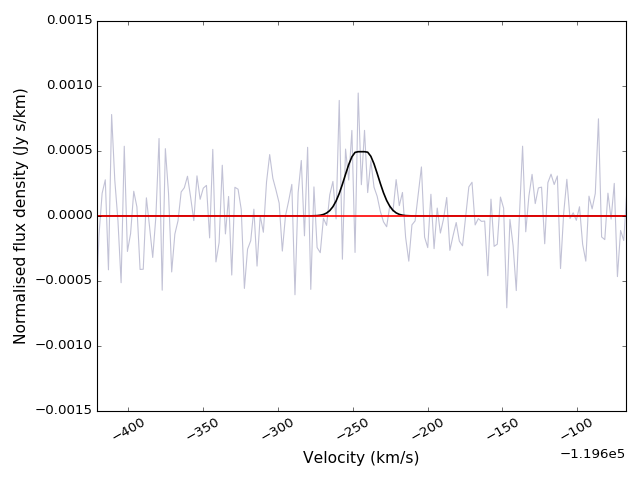

In [146]:
data_maker.plot_profile(df, plot_model=True, model_params=model_params, plot_fit=True, fit_params=fit_params,
                        zoom=True, rotation=30)

# Scratch

In [66]:
ind

'/ID77878992'

In [67]:
c=np.load('/home/michelle/BigData/HI_output/'+ind+'-post_equal_weights.dat.npy')

<IPython.core.display.Javascript object>


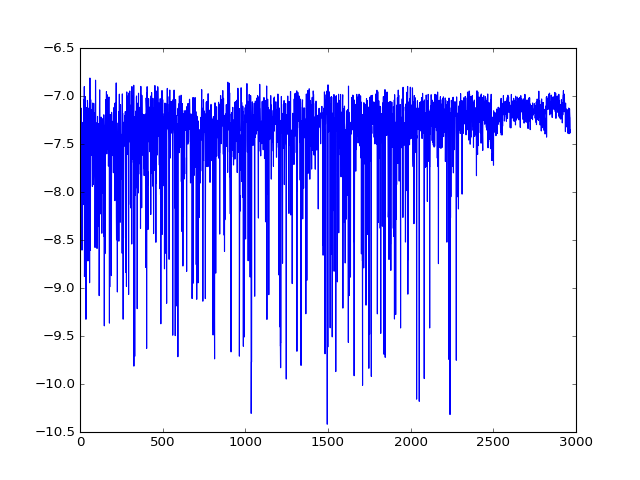

In [68]:
plt.figure()
plt.plot(c[:,5])
#a = plt.hist(c[:,5],25)

In [53]:
import pandas as pd

In [57]:
d = pd.read_csv('/home/michelle/Project/HI_fit/sub_z/91a09e81829d518c605c4601c9e52a7797d5e545.result')

In [71]:
d.hilumcenter.max()

0.0499

In [72]:
np.exp(-1)

0.36787944117144233

In [153]:
import os
pth='/home/michelle/BigData/HI_output/'
fls=os.listdir(pth)
for f in fls:
    if f[0] == ':':
        os.system('mv '+pth+f+' '+pth+f[1:])

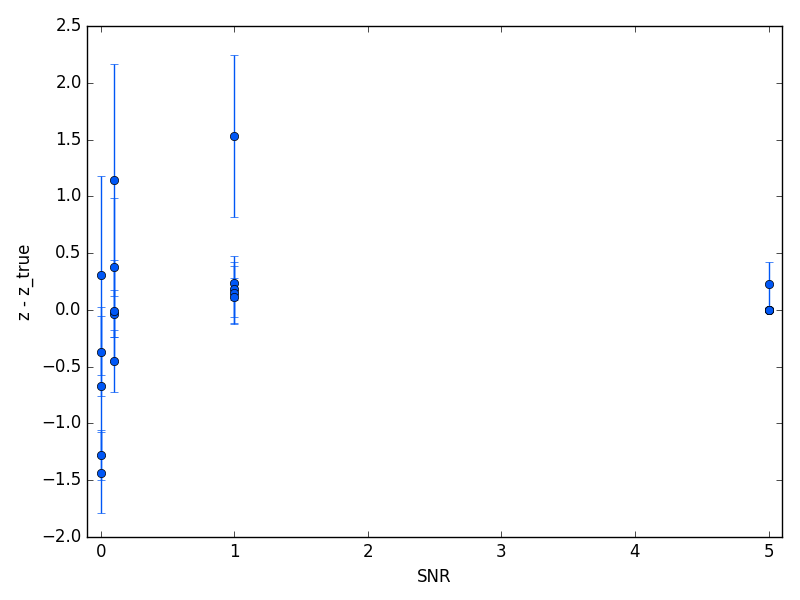

In [90]:
from IPython.display import Image
Image(filename='/home/michelle/BigData/HI_output/snr_analysis/SNR_vs_z.png') 